# For most sections, you don't need to change anything, simply run each cell in order. For the sections with **\[TODO\]** tags, there are actions on your side based on your textgrid files.

## 1. Install Dependencies

In [ ]:
%pip install praatio --upgrade
# %pip install pandas

In [ ]:
import os
from os.path import join

import pandas as pd
import csv

from praatio import textgrid
from praatio import audio
from praatio.praatio_scripts import spellCheckEntries, alignBoundariesAcrossTiers

import re

## 2. Upload textgrid files [TODO]

Upload your textgrid files by clicking on the folder icon on the left side 📁 and choose the file icon to upload to session storage

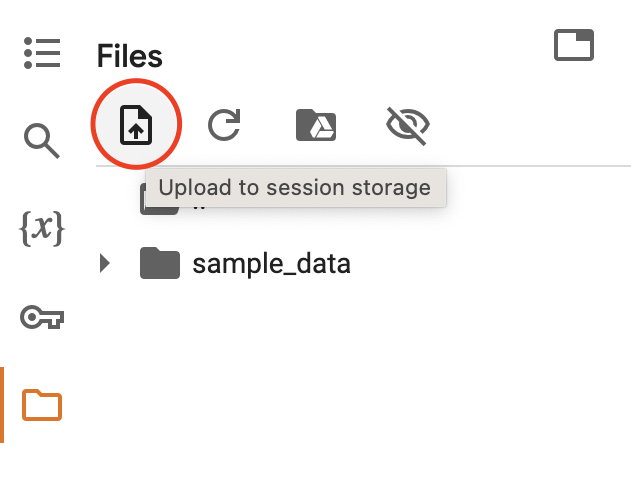

In [ ]:
# !ls
# check if your files have been uploaded, you should see all the file names like "sw....TextGrid"

file_names = [file for file in os.listdir(".") if file.lower().endswith(".textgrid")]
file_names

['sw2290_B.TextGrid',
 'sw2290_A.TextGrid',
 'sw2289_B.TextGrid',
 'sw2289_A.TextGrid']

## 3. Validate Textgrids

run all the following cells to load the functions for checking textgrids

In [ ]:
def load_textgrid(file_name):
    ''' Give it a file name, get back a Textgrid object '''
    tg = textgrid.openTextgrid(file_name, includeEmptyIntervals=True)
    return tg

In [ ]:
def zip_tiers(tg):
  ''' return a list of paired intervals in 2 tiers: [(t1_intv_i, t_2_intv_i)....]'''
  intervals = []
  for interval in zip(tg.getTier("Token").entries, tg.getTier("DA").entries):
    intervals.append(interval)
  return intervals

In [ ]:
def validate_interval(interval):
  ''' given a pair of interval (t1_intv_i, t2_intv_i) check if valid:
  1) time stamps match
  2) has transcript

  Returns tuple (valid, errors_list) with errors_list listing any problems with
  this interval
  '''
  errors = []
  valid = True

  if (interval[0].start != interval[1].start):
    errors.append('Token {} start does not match at {}, DA start is at {}'.format(interval[1].label, interval[0].start, interval[1].start))
    valid = False

  if (interval[0].end != interval[1].end):
    errors.append('Token {} end does not match at {}, DA end is at {}'.format(interval[1].label, interval[0].end, interval[1].end))
    valid = False

  if (interval[0].start == interval[0].end):
    errors.append('Zero length interval on Token tier at {}'.format(interval[0].start))
    valid = False

  if (interval[1].start == interval[1].end):
    errors.append('Zero length interval on DA tier at {}'.format(interval[1].start))
    valid = False

  if not interval[0].label:
    errors.append('Token does not have text at {}, {}'.format(interval[0].start, interval[0].end))
    valid = False

  if not interval[1].label:
    errors.append('DA is empty at {}, {}'.format(interval[1].start, interval[1].end))
    valid = False

  tags = {"sd", "b", "sv", "aa", "%", "ba", "qy", "ny", "fc", "qw", "nn",
        "bk", "h", "qy^d", "fo_o_fw_\"\"_by_bc", "bh", "^q", "bf", "na", "ad",
        "^2", "b^m", "qo", "qh", "^h", "ar", "ng", "br", "no", "fp", "qrr",
        "arp_nd", "t3", "oo_co_cc", "t1", "bd", "aap_am", "^g", "qw^d", "fa",
        "ft", "x", "+"} # includes tag for multi-segment utterances
                        # in praat, fo_o_fw_\"\"_by_bc is how fo_o_fw_"_by_bc
                        # is represented

  if not re.split("@|\*", interval[1].label)[0] in tags: # @ and * are special annotations added by SWDA creators, are not misannotations
    errors.append('DA "{}" not recognized at {}, {}'.format(interval[1].label,
                                                    interval[1].start,
                                                    interval[1].end))
    valid = False

  return valid, errors

In [ ]:
def validate_grid(tg):
  '''
  check if the textgrid is valid

  returns tuple (valid, errors) where errors_list is a list of lists, each
  entry is a list of errors for an interval flagged with at least one error
  '''
  errors = []
  valid = True

  if len(tg.getTier("Token")) != len(tg.getTier("DA")):
    errors.append(["Token and DA tiers are different lengths"])
    valid = False

  for interval_pair in zip_tiers(tg):
    result = validate_interval(interval_pair)

    if not result[0]:
      valid = False
      errors.append(result[1])

  return valid, errors

In [ ]:
def validate_files(file_list):
  '''
  check multiple files in file_list (list of file paths)
  returns tuple (file_name, valid, errors)
  '''
  output = []
  for file in file_list:
    tg = load_textgrid(file)
    output.append((file, validate_grid(tg)))

  return output

now check all your textgrids one by one

In [ ]:
validate_files(file_names)

[('sw2290_B.TextGrid',
  (False,
   [['DA "qyqy" not recognized at 4.827296113412212, 8.932389341231785'],
    ['Token % end does not match at 102.08746138199415, DA end is at 102.0986104167103'],
    ['Token b start does not match at 102.08746138199415, DA start is at 102.0986104167103'],
    ['DA is empty at 130.89000498845965, 149.73501741665015',
     'DA "" not recognized at 130.89000498845965, 149.73501741665015'],
    ['DA "svx" not recognized at 353.3938491783207, 355.0267840877396']])),
 ('sw2290_A.TextGrid', (True, [])),
 ('sw2289_B.TextGrid',
  (False,
   [['Token does not have text at 277.3148740385651, 277.6820879256288']])),
 ('sw2289_A.TextGrid', (True, []))]

## 4. Align the misaligned boundaries [TODO]

In [ ]:
fix_this_file = "" ## ADD THE FILE NAME (sw0000.TextGrid) THAT YOU WOULD LIKE TO FIX

tg = load_textgrid(fix_this_file)
display("Before:", validate_grid(tg))

print("\n")

tg_aligned = alignBoundariesAcrossTiers(tg, "Token", maxDifference=0.1) # Using the token tier as the reference
display("After: ", validate_grid(tg_aligned))

'Before:'

(False,
 [['DA "qyqy" not recognized at 4.827296113412212, 8.932389341231785'],
  ['Token % end does not match at 102.08746138199415, DA end is at 102.0986104167103'],
  ['Token b start does not match at 102.08746138199415, DA start is at 102.0986104167103'],
  ['DA is empty at 130.89000498845965, 149.73501741665015',
   'DA "" not recognized at 130.89000498845965, 149.73501741665015'],
  ['DA "svx" not recognized at 353.3938491783207, 355.0267840877396']])

'After: '

(False,
 [['DA "qyqy" not recognized at 4.827296113412212, 8.932389341231785'],
  ['DA is empty at 130.89000498845965, 149.73501741665015',
   'DA "" not recognized at 130.89000498845965, 149.73501741665015'],
  ['DA "svx" not recognized at 353.3938491783207, 355.0267840877396']])

## 5. Save the corrected textgrids [TODO]

In [ ]:
output_name = fix_this_file # this will replace the old file
tg.save(output_name, "long_textgrid", True, tg.minTimestamp, tg.maxTimestamp)
print("saved!")

saved!


# **REMEMBER**: download all the corrected files, because they are in temporary memory of this session on colab

## 6. Misc

### How do I find all the intervals with silence SIL?

In [ ]:
tier_token = tg.getTier('Token')
print(tier_token.find("SIL"))

### turn tg into csv for easy check

In [ ]:
tier_token = tg.getTier('Token').entries
tier_DA = tg.getTier('DA').entries
# Specify the output CSV file path
csv_file_path = 'intervals.csv'

# Writing to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['Token', 'start_token', 'end_token', 'DA', 'start_da', 'end_da'])
    
    # Get entries on 2 tiers
    tier_token = tg.getTier('Token').entries
    tier_da = tg.getTier('DA').entries

    # Write the interval data
    for i in range(max(len(tier_token), len(tier_DA))):
        interval_token, interval_da= tier_token[i], tier_da[i]
        writer.writerow([interval_token.label, interval_token.start, interval_token.end, 
                         interval_da.label, interval_da.start, interval_da.end])
print(f'Data has been written to {csv_file_path}')